# Logits to Categorical Distribution

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
PI = torch.Tensor([math.pi])

In [4]:
def create_animation_logits(intermediate_results):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    sc = ax.scatter(preds[:, 0], preds[:, 1], preds[:, 2], c=target)

    # manually relim:
    xmin = 1e7; xmax = 1e-7;
    ymin = 1e7; ymax = 1e-7;
    zmin = 1e7; zmax = 1e-7;
    for preds in intermediate_results:
        xmin=min(preds[:,0].min(), xmin); xmax=max(preds[:,0].max(), xmax)
        ymin=min(preds[:,1].min(), ymin); ymax=max(preds[:,1].max(), ymax)
        zmin=min(preds[:,2].min(), zmin); zmax=max(preds[:,2].max(), zmax)

    xmin = max(xmin, -10.); xmax = min(xmax, 10.)
    ymin = max(xmin, -10.); ymax = min(ymax, 10.)
    zmin = max(xmin, -10.); zmax = min(zmax, 10.)

    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        sc._offsets3d = (preds[:, 0], preds[:, 1], preds[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    
    return ani

In [5]:
def create_animation_simplex(intermediate_results, target):
    
    fig, ax = plt.subplots()
    
    probs = softmax(intermediate_results[0], 1)
    
    ax = plot_prob_simplex(probs, target, ax=ax, title='Output probabilities')
    
    def update_scat(i):
        probs = softmax(intermediate_results[i], 1)
        for j, collection in enumerate(ax.ax.collections):
            collection.set_offsets(np.array(project_sequence(probs[target==j])).T)
        ax._redraw_labels()

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [6]:
def nll(probs, target):
    return np.mean(-np.log(probs[np.arange(probs.shape[0]), target]))

## Base distributions of uncalibrated logits

* Separable case
* Mixed case

In [7]:
n_samples = 1500
dim = 3

### Separable

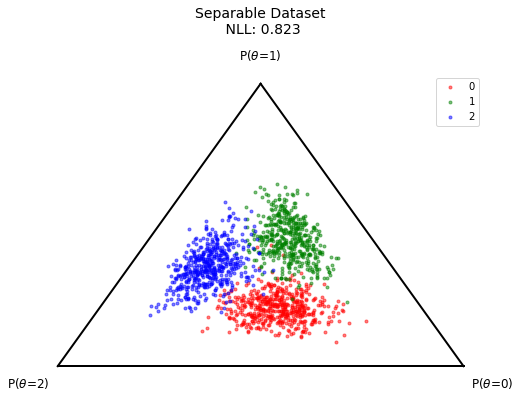

In [8]:
easy_target = np.array(random.choices(range(3), k=n_samples))
one_hot = np.zeros((n_samples, 3))
one_hot[np.arange(n_samples), easy_target] = 1.

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.05

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), easy_target-1] = 0.7 + np.random.randn(n_samples)*0.1

easy_logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# Equivalent to log(softmax())
easy_logits -= np.log(np.sum(np.exp(easy_logits), axis=1, keepdims=True))

easy_probs = softmax(easy_logits, axis=1)

# Convert data to torch tensors.
torch_easy_logits = torch.as_tensor(easy_logits, dtype=torch.float)
torch_easy_target = torch.as_tensor(easy_target, dtype=torch.long)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(easy_probs, easy_target, ax=ax, title='Separable Dataset\n NLL: {:.3f}'.format(nll(easy_probs, easy_target)))

plt.show(fig)

### Mixed

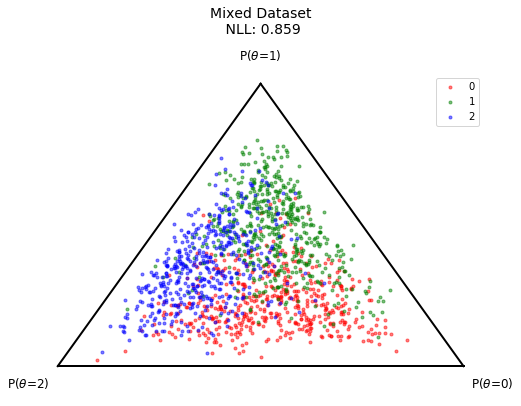

In [9]:
hard_target = np.array(random.choices(range(dim), k=n_samples))
one_hot = np.zeros((n_samples, dim))
one_hot[np.arange(n_samples), hard_target] = 1.

# Shift
offset = np.zeros((n_samples, dim))
offset[:, 1:] = 0.2

# Twist
twisting = np.zeros((n_samples, dim))
twisting[np.arange(n_samples), hard_target-1] = 0.6 + np.random.randn(n_samples)*0.3

hard_logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, dim)*0.6) + offset)

# Equivalent to log(softmax())
hard_logits -= np.log(np.sum(np.exp(hard_logits), axis=1, keepdims=True))

hard_probs = softmax(hard_logits, axis=1)

# Convert data to torch tensors.
torch_hard_logits = torch.as_tensor(hard_logits, dtype=torch.float)
torch_hard_target = torch.as_tensor(hard_target, dtype=torch.long)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(hard_probs, hard_target, ax=ax, title='Mixed Dataset\n NLL: {:.3f}'.format(nll(hard_probs, hard_target)))

plt.show(fig)

## Define Flows

In [10]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_size=[], activation=F.relu):
        super(MLP, self).__init__()
        self.activation = activation
        units = [dim] + hidden_size + [dim]
        self.layers = nn.ModuleList([nn.Linear(units[i], units[i+1])
                                     for i in range(len(units)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        y = self.layers[-1](x)

        return y

In [11]:
class AffineConstantLayer(nn.Module):

    def __init__(self, dim, scale=True, shift=True):
        super(AffineConstantLayer, self).__init__()

        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if shift else None

    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [12]:
class NvpCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_size=[5, 5], random_mask=True, max_abs=None):
        super(NvpCouplingLayer, self).__init__()
        self.s = MLP(dim, hidden_size)
        self.t = MLP(dim, hidden_size)
        
        # Use random partitioning of the data
        mask = np.random.randint(2, size=dim)
        if random_mask:
            while mask.sum() < 1 or mask.sum() == dim:
                mask = np.random.randint(2, size=dim)
        else:
            mask = np.zeros((1, dim))
            mask[:, dim//2:] = 1
            
        self.mask = nn.Parameter(
                torch.as_tensor(mask.copy(), dtype=torch.float),
                requires_grad=False)
        
        self.max_abs = max_abs

    def forward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1 * (x * torch.exp(s) + t)

        log_det = torch.sum(b_1*s, dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

    def backward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1*((x - t) * torch.exp(-s))

        log_det = torch.sum(b_1*(-s), dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

In [13]:
class Flow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(Flow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.log_det = nn.Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        zs = []
        for layer in self.layers:
            x, log_det = layer(x)
            zs.append(x)
            cum_log_det += log_det
            
        return zs, cum_log_det
            
    def backward(self, z):
        cum_log_det = self.log_det.new_full((z.shape[0],), fill_value=0)
        xs = []
        for layer in self.layers[::-1]:
            z, log_det = layer.backward(z)
            xs.append(z)
            cum_log_det += log_det

        return xs, cum_log_det

## NVP-like flow separable case

In [14]:
model = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(10)])
dev = torch.device('cpu')

In [15]:
epochs = 15000

In [16]:
model = model.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss = []
logpz = []
logdet = []

n_layers = 5  # Layers to monitor

# Output at some layers
logits_mean = []
logits_size = []

softmx = nn.Softmax(dim=1)

intermediate_results = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    zs, _logdet = model(torch_easy_logits)
    preds = zs[-1]
    _probs = softmx(preds)
    
    means = []
    sizes = []
    for i in range(0, len(model.layers), len(model.layers)//n_layers):
        z = zs[i].detach().numpy()
        means.append(np.mean(z))
        sizes.append(np.mean(np.linalg.norm(z-np.mean(z, axis=1, keepdims=True), axis=1)))

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.log(_probs.gather(1, torch_easy_target.view(-1, 1))))
    _loss = -_logpz - _logdet
    
    if (preds != preds).any():
        break

    _loss.backward()
    optimizer.step()

    loss.append(_loss.item())
    logpz.append(_logpz.item())
    logdet.append(_logdet.item())
    
    logits_mean.append(means)
    logits_size.append(sizes)

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1])
              + ', log(det): {:.3f}, mean(logits): {:.3f}, size(logits): {:.3f}'.format(logdet[-1],
                                                                                        np.mean(np.array(logits_mean[-1])),
                                                                                        np.mean(np.array(logits_size[-1])))
             )
        intermediate_results.append(preds.detach().numpy())

epoch: 9, at time: 0.90, loss: 1.589, log(pz): -1.710, log(det): 0.121, mean(logits): -1.698, size(logits): 1.804
epoch: 19, at time: 1.51, loss: 1.584, log(pz): -1.706, log(det): 0.122, mean(logits): -1.698, size(logits): 1.800
epoch: 29, at time: 2.09, loss: 1.578, log(pz): -1.701, log(det): 0.123, mean(logits): -1.697, size(logits): 1.797
epoch: 39, at time: 2.74, loss: 1.573, log(pz): -1.697, log(det): 0.124, mean(logits): -1.696, size(logits): 1.794
epoch: 49, at time: 3.33, loss: 1.568, log(pz): -1.693, log(det): 0.125, mean(logits): -1.695, size(logits): 1.791
epoch: 59, at time: 3.92, loss: 1.563, log(pz): -1.689, log(det): 0.126, mean(logits): -1.695, size(logits): 1.788
epoch: 69, at time: 4.57, loss: 1.558, log(pz): -1.685, log(det): 0.127, mean(logits): -1.694, size(logits): 1.784
epoch: 79, at time: 5.18, loss: 1.553, log(pz): -1.681, log(det): 0.128, mean(logits): -1.694, size(logits): 1.781
epoch: 89, at time: 5.80, loss: 1.548, log(pz): -1.677, log(det): 0.129, mean(log

epoch: 719, at time: 45.02, loss: 1.244, log(pz): -1.500, log(det): 0.256, mean(logits): -1.700, size(logits): 1.682
epoch: 729, at time: 45.64, loss: 1.239, log(pz): -1.498, log(det): 0.259, mean(logits): -1.701, size(logits): 1.681
epoch: 739, at time: 46.33, loss: 1.234, log(pz): -1.496, log(det): 0.262, mean(logits): -1.701, size(logits): 1.681
epoch: 749, at time: 46.94, loss: 1.229, log(pz): -1.494, log(det): 0.264, mean(logits): -1.702, size(logits): 1.681
epoch: 759, at time: 47.58, loss: 1.225, log(pz): -1.492, log(det): 0.267, mean(logits): -1.703, size(logits): 1.680
epoch: 769, at time: 48.26, loss: 1.220, log(pz): -1.490, log(det): 0.270, mean(logits): -1.704, size(logits): 1.680
epoch: 779, at time: 48.83, loss: 1.215, log(pz): -1.488, log(det): 0.273, mean(logits): -1.705, size(logits): 1.680
epoch: 789, at time: 49.34, loss: 1.210, log(pz): -1.486, log(det): 0.276, mean(logits): -1.705, size(logits): 1.679
epoch: 799, at time: 49.92, loss: 1.205, log(pz): -1.484, log(de

epoch: 1419, at time: 89.38, loss: 0.888, log(pz): -1.384, log(det): 0.495, mean(logits): -1.780, size(logits): 1.693
epoch: 1429, at time: 90.01, loss: 0.883, log(pz): -1.382, log(det): 0.499, mean(logits): -1.781, size(logits): 1.694
epoch: 1439, at time: 90.64, loss: 0.878, log(pz): -1.381, log(det): 0.503, mean(logits): -1.783, size(logits): 1.694
epoch: 1449, at time: 91.32, loss: 0.873, log(pz): -1.379, log(det): 0.506, mean(logits): -1.784, size(logits): 1.695
epoch: 1459, at time: 91.95, loss: 0.867, log(pz): -1.378, log(det): 0.510, mean(logits): -1.785, size(logits): 1.695
epoch: 1469, at time: 92.62, loss: 0.862, log(pz): -1.376, log(det): 0.514, mean(logits): -1.787, size(logits): 1.696
epoch: 1479, at time: 93.22, loss: 0.857, log(pz): -1.375, log(det): 0.518, mean(logits): -1.788, size(logits): 1.696
epoch: 1489, at time: 93.89, loss: 0.852, log(pz): -1.373, log(det): 0.522, mean(logits): -1.790, size(logits): 1.697
epoch: 1499, at time: 94.56, loss: 0.846, log(pz): -1.37

epoch: 2109, at time: 134.59, loss: 0.522, log(pz): -1.293, log(det): 0.771, mean(logits): -1.889, size(logits): 1.739
epoch: 2119, at time: 135.25, loss: 0.517, log(pz): -1.292, log(det): 0.775, mean(logits): -1.891, size(logits): 1.740
epoch: 2129, at time: 135.93, loss: 0.511, log(pz): -1.291, log(det): 0.779, mean(logits): -1.892, size(logits): 1.741
epoch: 2139, at time: 136.56, loss: 0.506, log(pz): -1.289, log(det): 0.783, mean(logits): -1.894, size(logits): 1.742
epoch: 2149, at time: 137.24, loss: 0.501, log(pz): -1.288, log(det): 0.788, mean(logits): -1.896, size(logits): 1.743
epoch: 2159, at time: 137.92, loss: 0.495, log(pz): -1.287, log(det): 0.792, mean(logits): -1.898, size(logits): 1.744
epoch: 2169, at time: 138.63, loss: 0.490, log(pz): -1.286, log(det): 0.797, mean(logits): -1.900, size(logits): 1.745
epoch: 2179, at time: 139.27, loss: 0.484, log(pz): -1.285, log(det): 0.801, mean(logits): -1.902, size(logits): 1.746
epoch: 2189, at time: 139.86, loss: 0.479, log(p

epoch: 2799, at time: 178.38, loss: 0.138, log(pz): -1.232, log(det): 1.094, mean(logits): -2.037, size(logits): 1.828
epoch: 2809, at time: 178.96, loss: 0.132, log(pz): -1.231, log(det): 1.099, mean(logits): -2.039, size(logits): 1.830
epoch: 2819, at time: 179.52, loss: 0.127, log(pz): -1.231, log(det): 1.104, mean(logits): -2.042, size(logits): 1.832
epoch: 2829, at time: 180.17, loss: 0.121, log(pz): -1.230, log(det): 1.109, mean(logits): -2.044, size(logits): 1.834
epoch: 2839, at time: 180.77, loss: 0.115, log(pz): -1.230, log(det): 1.115, mean(logits): -2.047, size(logits): 1.835
epoch: 2849, at time: 181.37, loss: 0.109, log(pz): -1.229, log(det): 1.120, mean(logits): -2.049, size(logits): 1.837
epoch: 2859, at time: 182.04, loss: 0.104, log(pz): -1.229, log(det): 1.125, mean(logits): -2.052, size(logits): 1.839
epoch: 2869, at time: 182.64, loss: 0.098, log(pz): -1.228, log(det): 1.130, mean(logits): -2.054, size(logits): 1.841
epoch: 2879, at time: 183.34, loss: 0.092, log(p

epoch: 3489, at time: 222.44, loss: -0.252, log(pz): -1.221, log(det): 1.473, mean(logits): -2.227, size(logits): 1.981
epoch: 3499, at time: 223.14, loss: -0.257, log(pz): -1.221, log(det): 1.479, mean(logits): -2.230, size(logits): 1.984
epoch: 3509, at time: 223.82, loss: -0.263, log(pz): -1.221, log(det): 1.484, mean(logits): -2.233, size(logits): 1.987
epoch: 3519, at time: 224.42, loss: -0.268, log(pz): -1.222, log(det): 1.490, mean(logits): -2.236, size(logits): 1.989
epoch: 3529, at time: 225.03, loss: -0.274, log(pz): -1.222, log(det): 1.496, mean(logits): -2.239, size(logits): 1.992
epoch: 3539, at time: 225.70, loss: -0.279, log(pz): -1.222, log(det): 1.501, mean(logits): -2.242, size(logits): 1.994
epoch: 3549, at time: 226.28, loss: -0.285, log(pz): -1.222, log(det): 1.507, mean(logits): -2.244, size(logits): 1.997
epoch: 3559, at time: 226.84, loss: -0.290, log(pz): -1.223, log(det): 1.513, mean(logits): -2.247, size(logits): 2.000
epoch: 3569, at time: 227.47, loss: -0.2

epoch: 4179, at time: 265.95, loss: -0.626, log(pz): -1.251, log(det): 1.877, mean(logits): -2.436, size(logits): 2.186
epoch: 4189, at time: 266.52, loss: -0.631, log(pz): -1.251, log(det): 1.883, mean(logits): -2.440, size(logits): 2.190
epoch: 4199, at time: 267.06, loss: -0.637, log(pz): -1.252, log(det): 1.889, mean(logits): -2.443, size(logits): 2.193
epoch: 4209, at time: 267.71, loss: -0.642, log(pz): -1.253, log(det): 1.895, mean(logits): -2.446, size(logits): 2.197
epoch: 4219, at time: 268.33, loss: -0.648, log(pz): -1.253, log(det): 1.901, mean(logits): -2.449, size(logits): 2.200
epoch: 4229, at time: 268.99, loss: -0.653, log(pz): -1.254, log(det): 1.907, mean(logits): -2.452, size(logits): 2.204
epoch: 4239, at time: 269.52, loss: -0.659, log(pz): -1.254, log(det): 1.913, mean(logits): -2.455, size(logits): 2.207
epoch: 4249, at time: 270.08, loss: -0.664, log(pz): -1.255, log(det): 1.919, mean(logits): -2.458, size(logits): 2.211
epoch: 4259, at time: 270.73, loss: -0.6

epoch: 4869, at time: 309.26, loss: -1.011, log(pz): -1.304, log(det): 2.315, mean(logits): -2.680, size(logits): 2.470
epoch: 4879, at time: 309.88, loss: -1.017, log(pz): -1.305, log(det): 2.322, mean(logits): -2.684, size(logits): 2.475
epoch: 4889, at time: 310.59, loss: -1.023, log(pz): -1.306, log(det): 2.329, mean(logits): -2.688, size(logits): 2.480
epoch: 4899, at time: 311.27, loss: -1.029, log(pz): -1.307, log(det): 2.335, mean(logits): -2.692, size(logits): 2.485
epoch: 4909, at time: 311.95, loss: -1.034, log(pz): -1.308, log(det): 2.342, mean(logits): -2.697, size(logits): 2.490
epoch: 4919, at time: 312.57, loss: -1.040, log(pz): -1.309, log(det): 2.349, mean(logits): -2.701, size(logits): 2.495
epoch: 4929, at time: 313.24, loss: -1.046, log(pz): -1.310, log(det): 2.356, mean(logits): -2.705, size(logits): 2.500
epoch: 4939, at time: 313.92, loss: -1.052, log(pz): -1.311, log(det): 2.363, mean(logits): -2.710, size(logits): 2.505
epoch: 4949, at time: 314.49, loss: -1.0

epoch: 5559, at time: 352.51, loss: -1.421, log(pz): -1.399, log(det): 2.819, mean(logits): -3.060, size(logits): 2.933
epoch: 5569, at time: 353.15, loss: -1.427, log(pz): -1.400, log(det): 2.828, mean(logits): -3.069, size(logits): 2.944
epoch: 5579, at time: 353.78, loss: -1.433, log(pz): -1.402, log(det): 2.836, mean(logits): -3.077, size(logits): 2.955
epoch: 5589, at time: 354.34, loss: -1.440, log(pz): -1.404, log(det): 2.844, mean(logits): -3.086, size(logits): 2.966
epoch: 5599, at time: 354.99, loss: -1.446, log(pz): -1.406, log(det): 2.852, mean(logits): -3.095, size(logits): 2.978
epoch: 5609, at time: 355.67, loss: -1.452, log(pz): -1.408, log(det): 2.860, mean(logits): -3.104, size(logits): 2.990
epoch: 5619, at time: 356.29, loss: -1.458, log(pz): -1.410, log(det): 2.869, mean(logits): -3.114, size(logits): 3.003
epoch: 5629, at time: 356.89, loss: -1.465, log(pz): -1.412, log(det): 2.877, mean(logits): -3.124, size(logits): 3.017
epoch: 5639, at time: 357.40, loss: -1.4

epoch: 6249, at time: 394.56, loss: -1.713, log(pz): -1.348, log(det): 3.061, mean(logits): -4.089, size(logits): 5.020
epoch: 6259, at time: 395.09, loss: -1.716, log(pz): -1.347, log(det): 3.062, mean(logits): -4.091, size(logits): 5.026
epoch: 6269, at time: 395.67, loss: -1.718, log(pz): -1.345, log(det): 3.063, mean(logits): -4.094, size(logits): 5.032
epoch: 6279, at time: 396.32, loss: -1.721, log(pz): -1.344, log(det): 3.064, mean(logits): -4.096, size(logits): 5.038
epoch: 6289, at time: 396.89, loss: -1.723, log(pz): -1.342, log(det): 3.066, mean(logits): -4.099, size(logits): 5.044
epoch: 6299, at time: 397.44, loss: -1.726, log(pz): -1.341, log(det): 3.067, mean(logits): -4.101, size(logits): 5.050
epoch: 6309, at time: 398.07, loss: -1.728, log(pz): -1.339, log(det): 3.068, mean(logits): -4.104, size(logits): 5.056
epoch: 6319, at time: 398.86, loss: -1.731, log(pz): -1.338, log(det): 3.069, mean(logits): -4.106, size(logits): 5.062
epoch: 6329, at time: 399.59, loss: -1.7

epoch: 6939, at time: 440.30, loss: -1.890, log(pz): -1.275, log(det): 3.164, mean(logits): -4.323, size(logits): 5.560
epoch: 6949, at time: 440.95, loss: -1.892, log(pz): -1.274, log(det): 3.166, mean(logits): -4.327, size(logits): 5.570
epoch: 6959, at time: 441.61, loss: -1.895, log(pz): -1.273, log(det): 3.168, mean(logits): -4.331, size(logits): 5.580
epoch: 6969, at time: 442.34, loss: -1.897, log(pz): -1.272, log(det): 3.170, mean(logits): -4.335, size(logits): 5.590
epoch: 6979, at time: 443.06, loss: -1.900, log(pz): -1.271, log(det): 3.172, mean(logits): -4.340, size(logits): 5.600
epoch: 6989, at time: 443.61, loss: -1.903, log(pz): -1.271, log(det): 3.173, mean(logits): -4.344, size(logits): 5.610
epoch: 6999, at time: 444.23, loss: -1.905, log(pz): -1.270, log(det): 3.175, mean(logits): -4.349, size(logits): 5.619
epoch: 7009, at time: 444.89, loss: -1.908, log(pz): -1.269, log(det): 3.177, mean(logits): -4.353, size(logits): 5.630
epoch: 7019, at time: 445.54, loss: -1.9

epoch: 7629, at time: 487.03, loss: -2.081, log(pz): -1.216, log(det): 3.297, mean(logits): -4.688, size(logits): 6.401
epoch: 7639, at time: 487.68, loss: -2.084, log(pz): -1.215, log(det): 3.299, mean(logits): -4.695, size(logits): 6.417
epoch: 7649, at time: 488.35, loss: -2.087, log(pz): -1.214, log(det): 3.301, mean(logits): -4.702, size(logits): 6.433
epoch: 7659, at time: 488.94, loss: -2.090, log(pz): -1.213, log(det): 3.303, mean(logits): -4.709, size(logits): 6.448
epoch: 7669, at time: 489.61, loss: -2.093, log(pz): -1.212, log(det): 3.305, mean(logits): -4.715, size(logits): 6.462
epoch: 7679, at time: 490.22, loss: -2.096, log(pz): -1.212, log(det): 3.307, mean(logits): -4.722, size(logits): 6.478
epoch: 7689, at time: 490.85, loss: -2.099, log(pz): -1.211, log(det): 3.309, mean(logits): -4.729, size(logits): 6.494
epoch: 7699, at time: 491.60, loss: -2.101, log(pz): -1.210, log(det): 3.311, mean(logits): -4.735, size(logits): 6.510
epoch: 7709, at time: 492.26, loss: -2.1

epoch: 8319, at time: 532.22, loss: -2.255, log(pz): -1.152, log(det): 3.407, mean(logits): -4.703, size(logits): 6.454
epoch: 8329, at time: 532.89, loss: -2.257, log(pz): -1.153, log(det): 3.411, mean(logits): -4.868, size(logits): 6.834
epoch: 8339, at time: 533.53, loss: -2.260, log(pz): -1.154, log(det): 3.414, mean(logits): -5.064, size(logits): 7.290
epoch: 8349, at time: 534.22, loss: -2.262, log(pz): -1.153, log(det): 3.415, mean(logits): -5.035, size(logits): 7.222
epoch: 8359, at time: 534.94, loss: -2.264, log(pz): -1.150, log(det): 3.414, mean(logits): -4.845, size(logits): 6.784
epoch: 8369, at time: 535.73, loss: -2.266, log(pz): -1.148, log(det): 3.414, mean(logits): -4.797, size(logits): 6.672
epoch: 8379, at time: 536.34, loss: -2.268, log(pz): -1.148, log(det): 3.417, mean(logits): -4.904, size(logits): 6.922
epoch: 8389, at time: 536.93, loss: -2.271, log(pz): -1.149, log(det): 3.420, mean(logits): -5.081, size(logits): 7.331
epoch: 8399, at time: 537.52, loss: -2.2

epoch: 9009, at time: 577.01, loss: -2.412, log(pz): -1.095, log(det): 3.507, mean(logits): -5.346, size(logits): 7.972
epoch: 9019, at time: 577.66, loss: -2.414, log(pz): -1.095, log(det): 3.509, mean(logits): -5.351, size(logits): 7.986
epoch: 9029, at time: 578.33, loss: -2.416, log(pz): -1.094, log(det): 3.510, mean(logits): -5.357, size(logits): 7.999
epoch: 9039, at time: 578.95, loss: -2.419, log(pz): -1.093, log(det): 3.512, mean(logits): -5.363, size(logits): 8.012
epoch: 9049, at time: 579.37, loss: -2.421, log(pz): -1.093, log(det): 3.514, mean(logits): -5.369, size(logits): 8.026
epoch: 9059, at time: 579.87, loss: -2.423, log(pz): -1.092, log(det): 3.515, mean(logits): -5.375, size(logits): 8.041
epoch: 9069, at time: 580.41, loss: -2.426, log(pz): -1.091, log(det): 3.517, mean(logits): -5.380, size(logits): 8.055
epoch: 9079, at time: 581.03, loss: -2.428, log(pz): -1.091, log(det): 3.519, mean(logits): -5.386, size(logits): 8.068
epoch: 9089, at time: 581.65, loss: -2.4

epoch: 9699, at time: 619.92, loss: -2.584, log(pz): -1.053, log(det): 3.637, mean(logits): -5.858, size(logits): 9.182
epoch: 9709, at time: 620.66, loss: -2.587, log(pz): -1.052, log(det): 3.639, mean(logits): -5.866, size(logits): 9.201
epoch: 9719, at time: 621.32, loss: -2.589, log(pz): -1.051, log(det): 3.641, mean(logits): -5.876, size(logits): 9.224
epoch: 9729, at time: 621.99, loss: -2.592, log(pz): -1.051, log(det): 3.643, mean(logits): -5.885, size(logits): 9.246
epoch: 9739, at time: 622.68, loss: -2.595, log(pz): -1.050, log(det): 3.645, mean(logits): -5.895, size(logits): 9.270
epoch: 9749, at time: 623.34, loss: -2.597, log(pz): -1.050, log(det): 3.647, mean(logits): -5.903, size(logits): 9.287
epoch: 9759, at time: 624.04, loss: -2.600, log(pz): -1.049, log(det): 3.649, mean(logits): -5.867, size(logits): 9.204
epoch: 9769, at time: 624.64, loss: -2.603, log(pz): -1.048, log(det): 3.650, mean(logits): -5.850, size(logits): 9.166
epoch: 9779, at time: 625.28, loss: -2.6

epoch: 10379, at time: 663.86, loss: -2.742, log(pz): -1.007, log(det): 3.749, mean(logits): -5.190, size(logits): 7.628
epoch: 10389, at time: 664.64, loss: -2.745, log(pz): -1.008, log(det): 3.753, mean(logits): -5.353, size(logits): 8.010
epoch: 10399, at time: 665.37, loss: -2.748, log(pz): -1.008, log(det): 3.756, mean(logits): -5.540, size(logits): 8.446
epoch: 10409, at time: 666.11, loss: -2.751, log(pz): -1.009, log(det): 3.760, mean(logits): -5.743, size(logits): 8.923
epoch: 10419, at time: 666.75, loss: -2.754, log(pz): -1.009, log(det): 3.763, mean(logits): -5.961, size(logits): 9.434
epoch: 10429, at time: 667.45, loss: -2.756, log(pz): -1.010, log(det): 3.766, mean(logits): -6.191, size(logits): 9.974
epoch: 10439, at time: 668.13, loss: -2.756, log(pz): -1.001, log(det): 3.757, mean(logits): -4.998, size(logits): 7.179
epoch: 10449, at time: 668.73, loss: -2.757, log(pz): -0.998, log(det): 3.755, mean(logits): -4.684, size(logits): 6.447
epoch: 10459, at time: 669.29, l

epoch: 11059, at time: 707.56, loss: -2.915, log(pz): -0.976, log(det): 3.891, mean(logits): -6.479, size(logits): 10.628
epoch: 11069, at time: 708.15, loss: -2.918, log(pz): -0.976, log(det): 3.893, mean(logits): -6.484, size(logits): 10.639
epoch: 11079, at time: 708.66, loss: -2.921, log(pz): -0.975, log(det): 3.896, mean(logits): -6.489, size(logits): 10.650
epoch: 11089, at time: 709.21, loss: -2.923, log(pz): -0.975, log(det): 3.898, mean(logits): -6.494, size(logits): 10.660
epoch: 11099, at time: 709.86, loss: -2.926, log(pz): -0.974, log(det): 3.900, mean(logits): -6.499, size(logits): 10.672
epoch: 11109, at time: 710.58, loss: -2.929, log(pz): -0.973, log(det): 3.902, mean(logits): -6.504, size(logits): 10.683
epoch: 11119, at time: 711.21, loss: -2.932, log(pz): -0.973, log(det): 3.905, mean(logits): -6.509, size(logits): 10.693
epoch: 11129, at time: 711.85, loss: -2.934, log(pz): -0.973, log(det): 3.907, mean(logits): -6.514, size(logits): 10.704
epoch: 11139, at time: 7

epoch: 11739, at time: 752.43, loss: -3.080, log(pz): -0.918, log(det): 3.998, mean(logits): -5.360, size(logits): 7.995
epoch: 11749, at time: 753.16, loss: -3.082, log(pz): -0.918, log(det): 4.000, mean(logits): -5.522, size(logits): 8.375
epoch: 11759, at time: 753.84, loss: -3.085, log(pz): -0.918, log(det): 4.003, mean(logits): -5.696, size(logits): 8.785
epoch: 11769, at time: 754.59, loss: -3.088, log(pz): -0.918, log(det): 4.006, mean(logits): -5.883, size(logits): 9.225
epoch: 11779, at time: 755.31, loss: -3.091, log(pz): -0.917, log(det): 4.008, mean(logits): -6.082, size(logits): 9.693
epoch: 11789, at time: 756.05, loss: -3.093, log(pz): -0.917, log(det): 4.010, mean(logits): -6.294, size(logits): 10.191
epoch: 11799, at time: 756.73, loss: -3.096, log(pz): -0.917, log(det): 4.013, mean(logits): -6.516, size(logits): 10.715
epoch: 11809, at time: 757.37, loss: -3.099, log(pz): -0.916, log(det): 4.015, mean(logits): -6.750, size(logits): 11.265
epoch: 11819, at time: 758.04

epoch: 12419, at time: 798.83, loss: -3.236, log(pz): -0.860, log(det): 4.096, mean(logits): -5.439, size(logits): 8.201
epoch: 12429, at time: 799.53, loss: -3.239, log(pz): -0.859, log(det): 4.098, mean(logits): -5.447, size(logits): 8.220
epoch: 12439, at time: 800.18, loss: -3.241, log(pz): -0.859, log(det): 4.101, mean(logits): -5.551, size(logits): 8.463
epoch: 12449, at time: 800.82, loss: -3.244, log(pz): -0.860, log(det): 4.104, mean(logits): -5.696, size(logits): 8.804
epoch: 12459, at time: 801.54, loss: -3.247, log(pz): -0.860, log(det): 4.107, mean(logits): -5.863, size(logits): 9.198
epoch: 12469, at time: 802.13, loss: -3.250, log(pz): -0.860, log(det): 4.110, mean(logits): -6.047, size(logits): 9.630
epoch: 12479, at time: 802.76, loss: -3.252, log(pz): -0.860, log(det): 4.112, mean(logits): -6.244, size(logits): 10.094
epoch: 12489, at time: 803.47, loss: -3.255, log(pz): -0.860, log(det): 4.115, mean(logits): -6.452, size(logits): 10.585
epoch: 12499, at time: 804.10,

epoch: 13099, at time: 844.95, loss: -3.399, log(pz): -0.812, log(det): 4.212, mean(logits): -6.902, size(logits): 11.663
epoch: 13109, at time: 845.63, loss: -3.402, log(pz): -0.812, log(det): 4.214, mean(logits): -7.126, size(logits): 12.192
epoch: 13119, at time: 846.39, loss: -3.400, log(pz): -0.801, log(det): 4.202, mean(logits): -5.213, size(logits): 7.692
epoch: 13129, at time: 847.13, loss: -3.401, log(pz): -0.797, log(det): 4.198, mean(logits): -4.831, size(logits): 6.796
epoch: 13139, at time: 847.76, loss: -3.403, log(pz): -0.797, log(det): 4.200, mean(logits): -4.777, size(logits): 6.669
epoch: 13149, at time: 848.41, loss: -3.406, log(pz): -0.797, log(det): 4.203, mean(logits): -4.818, size(logits): 6.764
epoch: 13159, at time: 849.08, loss: -3.408, log(pz): -0.798, log(det): 4.206, mean(logits): -4.895, size(logits): 6.944
epoch: 13169, at time: 849.63, loss: -3.411, log(pz): -0.798, log(det): 4.210, mean(logits): -4.990, size(logits): 7.167
epoch: 13179, at time: 850.30,

epoch: 13779, at time: 890.54, loss: -3.556, log(pz): -0.750, log(det): 4.306, mean(logits): -5.034, size(logits): 7.286
epoch: 13789, at time: 891.27, loss: -3.558, log(pz): -0.749, log(det): 4.307, mean(logits): -4.945, size(logits): 7.076
epoch: 13799, at time: 891.88, loss: -3.561, log(pz): -0.749, log(det): 4.310, mean(logits): -4.979, size(logits): 7.155
epoch: 13809, at time: 892.54, loss: -3.564, log(pz): -0.750, log(det): 4.314, mean(logits): -5.059, size(logits): 7.341
epoch: 13819, at time: 893.29, loss: -3.567, log(pz): -0.750, log(det): 4.317, mean(logits): -5.160, size(logits): 7.578
epoch: 13829, at time: 893.98, loss: -3.569, log(pz): -0.751, log(det): 4.320, mean(logits): -5.273, size(logits): 7.845
epoch: 13839, at time: 894.73, loss: -3.572, log(pz): -0.751, log(det): 4.323, mean(logits): -5.397, size(logits): 8.135
epoch: 13849, at time: 895.33, loss: -3.575, log(pz): -0.751, log(det): 4.326, mean(logits): -5.530, size(logits): 8.448
epoch: 13859, at time: 895.89, l

epoch: 14459, at time: 935.09, loss: -3.728, log(pz): -0.710, log(det): 4.438, mean(logits): -7.008, size(logits): 11.941
epoch: 14469, at time: 935.76, loss: -3.731, log(pz): -0.710, log(det): 4.441, mean(logits): -7.240, size(logits): 12.489
epoch: 14479, at time: 936.53, loss: -3.731, log(pz): -0.712, log(det): 4.443, mean(logits): -7.481, size(logits): 13.059
epoch: 14489, at time: 937.21, loss: -3.731, log(pz): -0.697, log(det): 4.427, mean(logits): -5.052, size(logits): 7.337
epoch: 14499, at time: 937.88, loss: -3.731, log(pz): -0.693, log(det): 4.424, mean(logits): -4.695, size(logits): 6.502
epoch: 14509, at time: 938.51, loss: -3.733, log(pz): -0.693, log(det): 4.426, mean(logits): -4.641, size(logits): 6.373
epoch: 14519, at time: 939.14, loss: -3.736, log(pz): -0.693, log(det): 4.429, mean(logits): -4.672, size(logits): 6.445
epoch: 14529, at time: 939.80, loss: -3.739, log(pz): -0.694, log(det): 4.433, mean(logits): -4.735, size(logits): 6.592
epoch: 14539, at time: 940.50

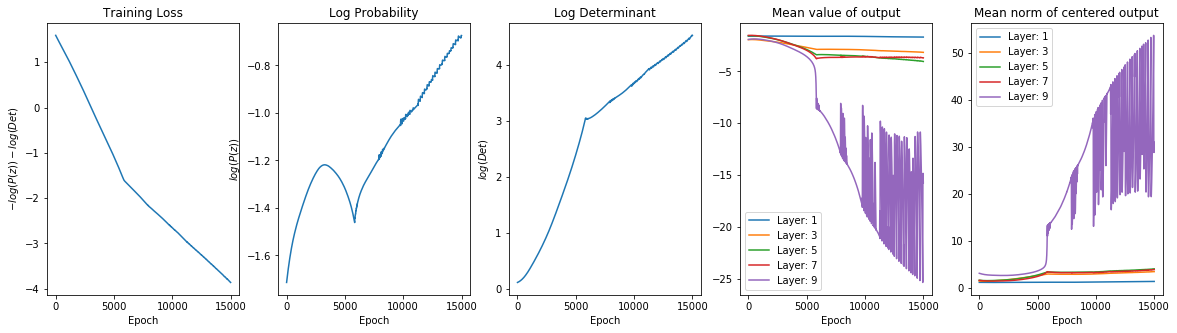

In [17]:
# Plot training NLL
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].plot(loss)
ax[1].plot(logpz)
ax[2].plot(logdet)
ax[3].plot(np.array(logits_mean))
ax[4].plot(np.array(logits_size))


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

ax[3].set_title('Mean value of output')
ax[3].set_xlabel('Epoch')
ax[3].legend(['Layer: {}'.format(i+1) for i in range(0, len(model.layers), len(model.layers)//n_layers)])

ax[4].set_title('Mean norm of centered output')
ax[4].set_xlabel('Epoch')
ax[4].legend(['Layer: {}'.format(i+1) for i in range(0, len(model.layers), len(model.layers)//n_layers)])

plt.show(fig)

In [18]:
ani = create_animation_simplex(intermediate_results, easy_target)

In [19]:
HTML(ani.to_html5_video())

## NVP-like flow mixed case

In [20]:
model2 = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(10)])
dev = torch.device('cpu')

In [21]:
epochs = 15000

In [22]:
model2 = model2.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5)

loss2 = []
logpz2 = []
logdet2 = []

n_layers = 5  # Layers to monitor

# Output at some layers
logits_mean2 = []
logits_size2 = []

softmx = nn.Softmax(dim=1)

intermediate_results2 = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    zs, _logdet = model2(torch_hard_logits)
    preds = zs[-1]
    _probs = softmx(preds)
    
    means = []
    sizes = []
    for i in range(0, len(model2.layers), len(model2.layers)//n_layers):
        z = zs[i].detach().numpy()
        means.append(np.mean(z))
        sizes.append(np.mean(np.linalg.norm(z-np.mean(z, axis=1, keepdims=True), axis=1)))

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.log(_probs.gather(1, torch_hard_target.view(-1, 1))))
    _loss = -_logpz - _logdet
    
    if (preds != preds).any():
        break

    _loss.backward()
    optimizer.step()

    loss2.append(_loss.item())
    logpz2.append(_logpz.item())
    logdet2.append(_logdet.item())
    
    logits_mean2.append(means)
    logits_size2.append(sizes)

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}'.format(e, time.time()-t0, loss2[-1], logpz2[-1])
              + ', log(det): {:.3f}, mean(logits): {:.3f}, size(logits): {:.3f}'.format(logdet2[-1],
                                                                                        np.mean(np.array(logits_mean2[-1])),
                                                                                        np.mean(np.array(logits_size2[-1])))
             )
        intermediate_results2.append(preds.detach().numpy())

epoch: 9, at time: 0.73, loss: 0.955, log(pz): -1.340, log(det): 0.385, mean(logits): -1.532, size(logits): 1.840
epoch: 19, at time: 1.37, loss: 0.951, log(pz): -1.340, log(det): 0.389, mean(logits): -1.533, size(logits): 1.841
epoch: 29, at time: 1.97, loss: 0.946, log(pz): -1.339, log(det): 0.393, mean(logits): -1.534, size(logits): 1.841
epoch: 39, at time: 2.61, loss: 0.942, log(pz): -1.338, log(det): 0.397, mean(logits): -1.535, size(logits): 1.842
epoch: 49, at time: 3.20, loss: 0.937, log(pz): -1.338, log(det): 0.401, mean(logits): -1.536, size(logits): 1.842
epoch: 59, at time: 3.84, loss: 0.932, log(pz): -1.337, log(det): 0.405, mean(logits): -1.537, size(logits): 1.843
epoch: 69, at time: 4.51, loss: 0.928, log(pz): -1.336, log(det): 0.409, mean(logits): -1.538, size(logits): 1.844
epoch: 79, at time: 5.23, loss: 0.923, log(pz): -1.335, log(det): 0.413, mean(logits): -1.539, size(logits): 1.844
epoch: 89, at time: 5.98, loss: 0.918, log(pz): -1.335, log(det): 0.416, mean(log

epoch: 719, at time: 46.12, loss: 0.611, log(pz): -1.294, log(det): 0.682, mean(logits): -1.614, size(logits): 1.897
epoch: 729, at time: 46.76, loss: 0.606, log(pz): -1.293, log(det): 0.687, mean(logits): -1.615, size(logits): 1.899
epoch: 739, at time: 47.29, loss: 0.601, log(pz): -1.292, log(det): 0.691, mean(logits): -1.616, size(logits): 1.900
epoch: 749, at time: 47.97, loss: 0.596, log(pz): -1.292, log(det): 0.696, mean(logits): -1.618, size(logits): 1.901
epoch: 759, at time: 48.64, loss: 0.591, log(pz): -1.291, log(det): 0.700, mean(logits): -1.619, size(logits): 1.902
epoch: 769, at time: 49.26, loss: 0.586, log(pz): -1.291, log(det): 0.705, mean(logits): -1.620, size(logits): 1.903
epoch: 779, at time: 50.02, loss: 0.581, log(pz): -1.290, log(det): 0.710, mean(logits): -1.622, size(logits): 1.904
epoch: 789, at time: 50.76, loss: 0.575, log(pz): -1.290, log(det): 0.714, mean(logits): -1.623, size(logits): 1.905
epoch: 799, at time: 51.52, loss: 0.570, log(pz): -1.289, log(de

epoch: 1419, at time: 94.16, loss: 0.237, log(pz): -1.259, log(det): 1.023, mean(logits): -1.717, size(logits): 1.998
epoch: 1429, at time: 94.85, loss: 0.231, log(pz): -1.259, log(det): 1.028, mean(logits): -1.719, size(logits): 2.000
epoch: 1439, at time: 95.54, loss: 0.225, log(pz): -1.259, log(det): 1.033, mean(logits): -1.720, size(logits): 2.002
epoch: 1449, at time: 96.12, loss: 0.220, log(pz): -1.258, log(det): 1.039, mean(logits): -1.722, size(logits): 2.003
epoch: 1459, at time: 96.87, loss: 0.214, log(pz): -1.258, log(det): 1.044, mean(logits): -1.724, size(logits): 2.005
epoch: 1469, at time: 97.60, loss: 0.208, log(pz): -1.258, log(det): 1.049, mean(logits): -1.726, size(logits): 2.007
epoch: 1479, at time: 98.35, loss: 0.203, log(pz): -1.257, log(det): 1.054, mean(logits): -1.727, size(logits): 2.009
epoch: 1489, at time: 99.06, loss: 0.197, log(pz): -1.257, log(det): 1.060, mean(logits): -1.729, size(logits): 2.011
epoch: 1499, at time: 99.70, loss: 0.191, log(pz): -1.25

epoch: 2109, at time: 140.59, loss: -0.168, log(pz): -1.248, log(det): 1.416, mean(logits): -1.850, size(logits): 2.159
epoch: 2119, at time: 141.37, loss: -0.174, log(pz): -1.248, log(det): 1.422, mean(logits): -1.852, size(logits): 2.162
epoch: 2129, at time: 142.12, loss: -0.180, log(pz): -1.248, log(det): 1.428, mean(logits): -1.855, size(logits): 2.165
epoch: 2139, at time: 142.82, loss: -0.186, log(pz): -1.248, log(det): 1.434, mean(logits): -1.857, size(logits): 2.168
epoch: 2149, at time: 143.44, loss: -0.192, log(pz): -1.248, log(det): 1.440, mean(logits): -1.859, size(logits): 2.171
epoch: 2159, at time: 144.14, loss: -0.199, log(pz): -1.248, log(det): 1.447, mean(logits): -1.861, size(logits): 2.174
epoch: 2169, at time: 144.79, loss: -0.205, log(pz): -1.248, log(det): 1.453, mean(logits): -1.864, size(logits): 2.177
epoch: 2179, at time: 145.46, loss: -0.211, log(pz): -1.248, log(det): 1.459, mean(logits): -1.866, size(logits): 2.180
epoch: 2189, at time: 146.13, loss: -0.2

epoch: 2799, at time: 186.66, loss: -0.594, log(pz): -1.278, log(det): 1.872, mean(logits): -2.019, size(logits): 2.399
epoch: 2809, at time: 187.35, loss: -0.601, log(pz): -1.278, log(det): 1.879, mean(logits): -2.022, size(logits): 2.403
epoch: 2819, at time: 188.08, loss: -0.607, log(pz): -1.279, log(det): 1.886, mean(logits): -2.025, size(logits): 2.407
epoch: 2829, at time: 188.74, loss: -0.613, log(pz): -1.280, log(det): 1.893, mean(logits): -2.028, size(logits): 2.411
epoch: 2839, at time: 189.33, loss: -0.619, log(pz): -1.281, log(det): 1.900, mean(logits): -2.030, size(logits): 2.415
epoch: 2849, at time: 189.91, loss: -0.625, log(pz): -1.282, log(det): 1.908, mean(logits): -2.033, size(logits): 2.419
epoch: 2859, at time: 190.61, loss: -0.632, log(pz): -1.283, log(det): 1.915, mean(logits): -2.036, size(logits): 2.424
epoch: 2869, at time: 191.24, loss: -0.638, log(pz): -1.284, log(det): 1.922, mean(logits): -2.039, size(logits): 2.428
epoch: 2879, at time: 191.88, loss: -0.6

epoch: 3489, at time: 233.58, loss: -1.009, log(pz): -1.378, log(det): 2.387, mean(logits): -2.219, size(logits): 2.721
epoch: 3499, at time: 234.26, loss: -1.015, log(pz): -1.381, log(det): 2.395, mean(logits): -2.222, size(logits): 2.726
epoch: 3509, at time: 234.89, loss: -1.020, log(pz): -1.383, log(det): 2.403, mean(logits): -2.225, size(logits): 2.731
epoch: 3519, at time: 235.56, loss: -1.026, log(pz): -1.385, log(det): 2.411, mean(logits): -2.228, size(logits): 2.737
epoch: 3529, at time: 236.18, loss: -1.032, log(pz): -1.387, log(det): 2.419, mean(logits): -2.231, size(logits): 2.742
epoch: 3539, at time: 236.83, loss: -1.038, log(pz): -1.389, log(det): 2.427, mean(logits): -2.234, size(logits): 2.747
epoch: 3549, at time: 237.48, loss: -1.043, log(pz): -1.391, log(det): 2.434, mean(logits): -2.237, size(logits): 2.752
epoch: 3559, at time: 238.20, loss: -1.049, log(pz): -1.394, log(det): 2.442, mean(logits): -2.241, size(logits): 2.758
epoch: 3569, at time: 238.94, loss: -1.0

epoch: 4179, at time: 280.66, loss: -1.379, log(pz): -1.558, log(det): 2.937, mean(logits): -2.427, size(logits): 3.112
epoch: 4189, at time: 281.25, loss: -1.384, log(pz): -1.561, log(det): 2.945, mean(logits): -2.429, size(logits): 3.118
epoch: 4199, at time: 282.01, loss: -1.389, log(pz): -1.564, log(det): 2.953, mean(logits): -2.432, size(logits): 3.124
epoch: 4209, at time: 282.67, loss: -1.394, log(pz): -1.567, log(det): 2.961, mean(logits): -2.435, size(logits): 3.130
epoch: 4219, at time: 283.38, loss: -1.399, log(pz): -1.570, log(det): 2.969, mean(logits): -2.438, size(logits): 3.136
epoch: 4229, at time: 284.06, loss: -1.404, log(pz): -1.573, log(det): 2.977, mean(logits): -2.441, size(logits): 3.143
epoch: 4239, at time: 284.74, loss: -1.409, log(pz): -1.576, log(det): 2.985, mean(logits): -2.444, size(logits): 3.149
epoch: 4249, at time: 285.41, loss: -1.414, log(pz): -1.579, log(det): 2.993, mean(logits): -2.447, size(logits): 3.155
epoch: 4259, at time: 286.17, loss: -1.4

epoch: 4869, at time: 327.94, loss: -1.711, log(pz): -1.759, log(det): 3.470, mean(logits): -2.609, size(logits): 3.536
epoch: 4879, at time: 328.63, loss: -1.716, log(pz): -1.762, log(det): 3.478, mean(logits): -2.611, size(logits): 3.542
epoch: 4889, at time: 329.31, loss: -1.720, log(pz): -1.765, log(det): 3.485, mean(logits): -2.614, size(logits): 3.548
epoch: 4899, at time: 330.01, loss: -1.725, log(pz): -1.767, log(det): 3.493, mean(logits): -2.616, size(logits): 3.554
epoch: 4909, at time: 330.67, loss: -1.730, log(pz): -1.770, log(det): 3.500, mean(logits): -2.618, size(logits): 3.560
epoch: 4919, at time: 331.38, loss: -1.734, log(pz): -1.773, log(det): 3.507, mean(logits): -2.621, size(logits): 3.566
epoch: 4929, at time: 332.09, loss: -1.739, log(pz): -1.776, log(det): 3.514, mean(logits): -2.623, size(logits): 3.572
epoch: 4939, at time: 332.81, loss: -1.743, log(pz): -1.779, log(det): 3.522, mean(logits): -2.625, size(logits): 3.578
epoch: 4949, at time: 333.50, loss: -1.7

epoch: 5559, at time: 373.07, loss: -1.944, log(pz): -1.893, log(det): 3.837, mean(logits): -2.695, size(logits): 3.712
epoch: 5569, at time: 373.67, loss: -1.947, log(pz): -1.893, log(det): 3.840, mean(logits): -2.695, size(logits): 3.712
epoch: 5579, at time: 374.21, loss: -1.949, log(pz): -1.894, log(det): 3.843, mean(logits): -2.695, size(logits): 3.712
epoch: 5589, at time: 374.84, loss: -1.952, log(pz): -1.894, log(det): 3.846, mean(logits): -2.695, size(logits): 3.712
epoch: 5599, at time: 375.42, loss: -1.954, log(pz): -1.895, log(det): 3.849, mean(logits): -2.695, size(logits): 3.712
epoch: 5609, at time: 376.06, loss: -1.957, log(pz): -1.895, log(det): 3.852, mean(logits): -2.695, size(logits): 3.712
epoch: 5619, at time: 376.61, loss: -1.960, log(pz): -1.896, log(det): 3.855, mean(logits): -2.695, size(logits): 3.712
epoch: 5629, at time: 377.27, loss: -1.962, log(pz): -1.896, log(det): 3.858, mean(logits): -2.695, size(logits): 3.712
epoch: 5639, at time: 377.89, loss: -1.9

epoch: 6249, at time: 419.00, loss: -2.108, log(pz): -1.896, log(det): 4.005, mean(logits): -2.675, size(logits): 3.677
epoch: 6259, at time: 419.78, loss: -2.111, log(pz): -1.896, log(det): 4.006, mean(logits): -2.674, size(logits): 3.675
epoch: 6269, at time: 420.57, loss: -2.113, log(pz): -1.895, log(det): 4.008, mean(logits): -2.674, size(logits): 3.674
epoch: 6279, at time: 421.31, loss: -2.115, log(pz): -1.895, log(det): 4.010, mean(logits): -2.673, size(logits): 3.673
epoch: 6289, at time: 421.99, loss: -2.117, log(pz): -1.894, log(det): 4.012, mean(logits): -2.673, size(logits): 3.672
epoch: 6299, at time: 422.61, loss: -2.119, log(pz): -1.894, log(det): 4.013, mean(logits): -2.672, size(logits): 3.671
epoch: 6309, at time: 423.22, loss: -2.122, log(pz): -1.894, log(det): 4.015, mean(logits): -2.672, size(logits): 3.669
epoch: 6319, at time: 423.91, loss: -2.124, log(pz): -1.893, log(det): 4.017, mean(logits): -2.671, size(logits): 3.668
epoch: 6329, at time: 424.62, loss: -2.1

epoch: 6939, at time: 465.39, loss: -2.256, log(pz): -1.864, log(det): 4.120, mean(logits): -2.636, size(logits): 3.596
epoch: 6949, at time: 466.01, loss: -2.258, log(pz): -1.864, log(det): 4.122, mean(logits): -2.636, size(logits): 3.595
epoch: 6959, at time: 466.75, loss: -2.260, log(pz): -1.863, log(det): 4.124, mean(logits): -2.635, size(logits): 3.594
epoch: 6969, at time: 467.39, loss: -2.262, log(pz): -1.863, log(det): 4.125, mean(logits): -2.635, size(logits): 3.593
epoch: 6979, at time: 468.05, loss: -2.265, log(pz): -1.863, log(det): 4.127, mean(logits): -2.634, size(logits): 3.592
epoch: 6989, at time: 468.77, loss: -2.267, log(pz): -1.862, log(det): 4.129, mean(logits): -2.634, size(logits): 3.592
epoch: 6999, at time: 469.49, loss: -2.269, log(pz): -1.862, log(det): 4.131, mean(logits): -2.633, size(logits): 3.591
epoch: 7009, at time: 470.15, loss: -2.271, log(pz): -1.862, log(det): 4.132, mean(logits): -2.633, size(logits): 3.590
epoch: 7019, at time: 470.92, loss: -2.2

epoch: 7629, at time: 512.65, loss: -2.397, log(pz): -1.834, log(det): 4.230, mean(logits): -2.604, size(logits): 3.539
epoch: 7639, at time: 513.27, loss: -2.399, log(pz): -1.833, log(det): 4.232, mean(logits): -2.604, size(logits): 3.538
epoch: 7649, at time: 513.85, loss: -2.401, log(pz): -1.833, log(det): 4.234, mean(logits): -2.604, size(logits): 3.537
epoch: 7659, at time: 514.54, loss: -2.403, log(pz): -1.832, log(det): 4.235, mean(logits): -2.603, size(logits): 3.537
epoch: 7669, at time: 515.15, loss: -2.405, log(pz): -1.832, log(det): 4.237, mean(logits): -2.603, size(logits): 3.536
epoch: 7679, at time: 515.88, loss: -2.407, log(pz): -1.831, log(det): 4.238, mean(logits): -2.602, size(logits): 3.535
epoch: 7689, at time: 516.62, loss: -2.409, log(pz): -1.831, log(det): 4.240, mean(logits): -2.602, size(logits): 3.534
epoch: 7699, at time: 517.32, loss: -2.411, log(pz): -1.830, log(det): 4.241, mean(logits): -2.601, size(logits): 3.533
epoch: 7709, at time: 518.06, loss: -2.4

epoch: 8319, at time: 559.36, loss: -2.529, log(pz): -1.802, log(det): 4.331, mean(logits): -2.578, size(logits): 3.487
epoch: 8329, at time: 560.10, loss: -2.531, log(pz): -1.801, log(det): 4.332, mean(logits): -2.578, size(logits): 3.486
epoch: 8339, at time: 560.78, loss: -2.533, log(pz): -1.801, log(det): 4.333, mean(logits): -2.578, size(logits): 3.485
epoch: 8349, at time: 561.41, loss: -2.535, log(pz): -1.800, log(det): 4.335, mean(logits): -2.577, size(logits): 3.485
epoch: 8359, at time: 562.15, loss: -2.536, log(pz): -1.800, log(det): 4.336, mean(logits): -2.577, size(logits): 3.484
epoch: 8369, at time: 562.77, loss: -2.538, log(pz): -1.799, log(det): 4.337, mean(logits): -2.577, size(logits): 3.483
epoch: 8379, at time: 563.47, loss: -2.540, log(pz): -1.798, log(det): 4.339, mean(logits): -2.576, size(logits): 3.482
epoch: 8389, at time: 564.24, loss: -2.542, log(pz): -1.798, log(det): 4.340, mean(logits): -2.576, size(logits): 3.482
epoch: 8399, at time: 565.02, loss: -2.5

epoch: 9009, at time: 606.14, loss: -2.654, log(pz): -1.770, log(det): 4.423, mean(logits): -2.559, size(logits): 3.444
epoch: 9019, at time: 606.76, loss: -2.656, log(pz): -1.769, log(det): 4.425, mean(logits): -2.559, size(logits): 3.443
epoch: 9029, at time: 607.38, loss: -2.658, log(pz): -1.768, log(det): 4.426, mean(logits): -2.559, size(logits): 3.443
epoch: 9039, at time: 608.06, loss: -2.659, log(pz): -1.767, log(det): 4.426, mean(logits): -2.558, size(logits): 3.442
epoch: 9049, at time: 608.78, loss: -2.661, log(pz): -1.765, log(det): 4.427, mean(logits): -2.558, size(logits): 3.441
epoch: 9059, at time: 609.41, loss: -2.663, log(pz): -1.764, log(det): 4.427, mean(logits): -2.558, size(logits): 3.441
epoch: 9069, at time: 610.06, loss: -2.665, log(pz): -1.764, log(det): 4.429, mean(logits): -2.558, size(logits): 3.440
epoch: 9079, at time: 610.73, loss: -2.667, log(pz): -1.763, log(det): 4.430, mean(logits): -2.557, size(logits): 3.440
epoch: 9089, at time: 611.40, loss: -2.6

epoch: 9699, at time: 651.73, loss: -2.779, log(pz): -1.737, log(det): 4.516, mean(logits): -2.546, size(logits): 3.410
epoch: 9709, at time: 652.41, loss: -2.780, log(pz): -1.737, log(det): 4.517, mean(logits): -2.545, size(logits): 3.409
epoch: 9719, at time: 653.05, loss: -2.782, log(pz): -1.736, log(det): 4.519, mean(logits): -2.545, size(logits): 3.409
epoch: 9729, at time: 653.72, loss: -2.784, log(pz): -1.736, log(det): 4.520, mean(logits): -2.545, size(logits): 3.409
epoch: 9739, at time: 654.35, loss: -2.786, log(pz): -1.736, log(det): 4.522, mean(logits): -2.545, size(logits): 3.409
epoch: 9749, at time: 654.93, loss: -2.788, log(pz): -1.735, log(det): 4.523, mean(logits): -2.545, size(logits): 3.408
epoch: 9759, at time: 655.68, loss: -2.790, log(pz): -1.735, log(det): 4.525, mean(logits): -2.545, size(logits): 3.408
epoch: 9769, at time: 656.38, loss: -2.792, log(pz): -1.735, log(det): 4.526, mean(logits): -2.545, size(logits): 3.408
epoch: 9779, at time: 657.06, loss: -2.7

epoch: 10379, at time: 695.32, loss: -2.905, log(pz): -1.714, log(det): 4.620, mean(logits): -2.538, size(logits): 3.396
epoch: 10389, at time: 695.97, loss: -2.907, log(pz): -1.714, log(det): 4.621, mean(logits): -2.538, size(logits): 3.396
epoch: 10399, at time: 696.67, loss: -2.909, log(pz): -1.714, log(det): 4.623, mean(logits): -2.537, size(logits): 3.396
epoch: 10409, at time: 697.29, loss: -2.911, log(pz): -1.714, log(det): 4.624, mean(logits): -2.537, size(logits): 3.395
epoch: 10419, at time: 697.91, loss: -2.913, log(pz): -1.713, log(det): 4.626, mean(logits): -2.537, size(logits): 3.395
epoch: 10429, at time: 698.45, loss: -2.915, log(pz): -1.713, log(det): 4.628, mean(logits): -2.537, size(logits): 3.395
epoch: 10439, at time: 699.14, loss: -2.917, log(pz): -1.713, log(det): 4.629, mean(logits): -2.537, size(logits): 3.395
epoch: 10449, at time: 699.86, loss: -2.919, log(pz): -1.712, log(det): 4.631, mean(logits): -2.536, size(logits): 3.395
epoch: 10459, at time: 700.64, l

epoch: 11059, at time: 741.06, loss: -3.041, log(pz): -1.713, log(det): 4.754, mean(logits): -2.527, size(logits): 3.413
epoch: 11069, at time: 741.66, loss: -3.044, log(pz): -1.714, log(det): 4.757, mean(logits): -2.526, size(logits): 3.417
epoch: 11079, at time: 742.30, loss: -3.046, log(pz): -1.716, log(det): 4.762, mean(logits): -2.526, size(logits): 3.421
epoch: 11089, at time: 742.86, loss: -3.049, log(pz): -1.719, log(det): 4.768, mean(logits): -2.525, size(logits): 3.427
epoch: 11099, at time: 743.47, loss: -3.053, log(pz): -1.723, log(det): 4.776, mean(logits): -2.523, size(logits): 3.438
epoch: 11109, at time: 744.18, loss: -3.057, log(pz): -1.730, log(det): 4.787, mean(logits): -2.519, size(logits): 3.458
epoch: 11119, at time: 744.85, loss: -3.066, log(pz): -1.742, log(det): 4.808, mean(logits): -2.506, size(logits): 3.514
epoch: 11129, at time: 745.47, loss: -3.112, log(pz): -1.766, log(det): 4.879, mean(logits): -2.385, size(logits): 3.871


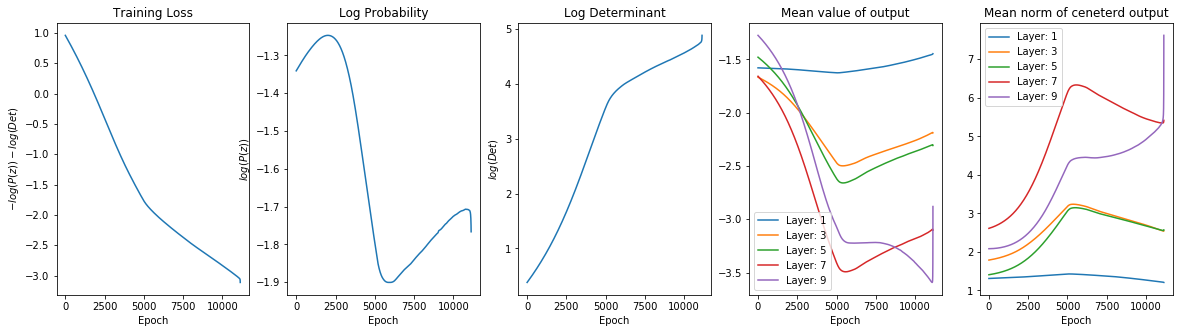

In [23]:
# Plot training NLL
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].plot(loss2)
ax[1].plot(logpz2)
ax[2].plot(logdet2)
ax[3].plot(np.array(logits_mean2))
ax[4].plot(np.array(logits_size2))


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

ax[3].set_title('Mean value of output')
ax[3].set_xlabel('Epoch')
ax[3].legend(['Layer: {}'.format(i+1) for i in range(0, len(model2.layers), len(model2.layers)//n_layers)])

ax[4].set_title('Mean norm of centered output')
ax[4].set_xlabel('Epoch')
ax[4].legend(['Layer: {}'.format(i+1) for i in range(0, len(model2.layers), len(model2.layers)//n_layers)])

plt.show(fig)

In [24]:
ani2 = create_animation_simplex(intermediate_results2, hard_target)

In [25]:
HTML(ani2.to_html5_video())

In [28]:
np.exp(100)

2.6881171418161356e+43